# 📦 Optimizing Logistics with Data: Delhivery Case Study
Delhivery is one of India's leading logistics and supply chain companies. Known for its extensive reach and advanced delivery solutions, the company integrates cutting-edge technology to enable timely and reliable services across diverse regions.
# 🔍 Project Objective
This project focuses on analyzing logistics and delivery performance using Delhivery’s raw operational data. The goal is to extract meaningful insights that can improve logistics strategies, route optimization, and delivery efficiency.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [39]:
delivery_data = pd.read_csv('delhivery.csv')

In [40]:
delivery_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   data                            144867 non-null  object 
 1   trip_creation_time              144867 non-null  object 
 2   route_schedule_uuid             144867 non-null  object 
 3   route_type                      144867 non-null  object 
 4   trip_uuid                       144867 non-null  object 
 5   source_center                   144867 non-null  object 
 6   source_name                     144574 non-null  object 
 7   destination_center              144867 non-null  object 
 8   destination_name                144606 non-null  object 
 9   od_start_time                   144867 non-null  object 
 10  od_end_time                     144867 non-null  object 
 11  start_scan_to_end_scan          144867 non-null  float64
 12  is_cutoff       

# 💡 Potential Use Cases
• Trip Efficiency Analysis: Evaluate the performance of different trips and identify delays or inefficiencies.

• Route Optimization: Understand how delivery routes are planned and executed using open-source routing engines.

• Transportation Modes: Assess how different types of transport affect delivery times.

• Performance Benchmarking: Track delivery KPIs such as time taken, distance covered, and trip success rates.


# 🧠 My Contribution
## 🧹 1. Data Cleaning & Feature Engineering
Processed and sanitized raw fields (e.g., timestamps, distances, geolocation).
Extracted features such as:
Average delivery time per route.
Delay metrics per trip or region.
Trip frequency by transport type.
## 📊 2. Exploratory Data Analysis (EDA)
Visualized trip durations, distances, and delays.
Identified outliers and anomalies.
Grouped data by city, zone, and transport type to find performance gaps.
## 📈 3. Insights & Recommendations
Suggested route optimization strategies based on trip repetition patterns.
Proposed filters for early detection of delivery failures.
Created dashboards for dynamic KPI monitoring.

In [41]:
# Check for missing values
print("Missing values in each column:")
print(delivery_data.isnull().sum())

Missing values in each column:
data                                0
trip_creation_time                  0
route_schedule_uuid                 0
route_type                          0
trip_uuid                           0
source_center                       0
source_name                       293
destination_center                  0
destination_name                  261
od_start_time                       0
od_end_time                         0
start_scan_to_end_scan              0
is_cutoff                           0
cutoff_factor                       0
cutoff_timestamp                    0
actual_distance_to_destination      0
actual_time                         0
osrm_time                           0
osrm_distance                       0
factor                              0
segment_actual_time                 0
segment_osrm_time                   0
segment_osrm_distance               0
segment_factor                      0
dtype: int64


### Handling Missing Values

During data inspection, I found missing values in the `source_name` and `destination_name` columns.  
To address this, I explored the possibility of imputing these values based on similarities with other columns such as:

- `source_lat` and `source_long`
- `destination_lat` and `destination_long`
- `trip_id` or `order_time`

This strategy helps retain valuable rows and ensures data completeness where patterns are identifiable.


In [42]:
# Asegurar que las columnas de coordenadas existan
for col in ['source_lat', 'source_long', 'destination_lat', 'destination_long']:
    if col not in delivery_data.columns:
        delivery_data[col] = np.nan

# --- Rellenar source_name basado en coordenadas ---
def fill_source_name(row):
    if pd.isna(row['source_name']):
        matches = delivery_data.loc[
            (delivery_data['source_lat'] == row['source_lat']) &
            (delivery_data['source_long'] == row['source_long']) &
            delivery_data['source_name'].notna(), 'source_name'
        ]
        if not matches.empty:
            return matches.mode().iloc[0]
    return row['source_name']

delivery_data['source_name'] = delivery_data.apply(fill_source_name, axis=1)

# --- Rellenar destination_name basado en coordenadas ---
def fill_destination_name(row):
    if pd.isna(row['destination_name']):
        matches = delivery_data.loc[
            (delivery_data['destination_lat'] == row['destination_lat']) &
            (delivery_data['destination_long'] == row['destination_long']) &
            delivery_data['destination_name'].notna(), 'destination_name'
        ]
        if not matches.empty:
            return matches.mode().iloc[0]
    return row['destination_name']

delivery_data['destination_name'] = delivery_data.apply(fill_destination_name, axis=1)

# Verificación final
print("✅ Missing source_name after fill:", delivery_data['source_name'].isna().sum())
print("✅ Missing destination_name after fill:", delivery_data['destination_name'].isna().sum())


✅ Missing source_name after fill: 293
✅ Missing destination_name after fill: 261


In [43]:
# Ver filas con source_name faltante
missing_source = delivery_data[delivery_data['source_name'].isna()]
# Ver si sus coordenadas existen más de una vez
source_coords_counts = delivery_data.groupby(['source_lat', 'source_long']).size().reset_index(name='count')
missing_source = missing_source.merge(source_coords_counts, on=['source_lat', 'source_long'], how='left')
print("Source coordinates that appear only once:")
print(missing_source[missing_source['count'] == 1].shape[0])

# Ver filas con destination_name faltante
missing_dest = delivery_data[delivery_data['destination_name'].isna()]
# Ver si sus coordenadas existen más de una vez
dest_coords_counts = delivery_data.groupby(['destination_lat', 'destination_long']).size().reset_index(name='count')
missing_dest = missing_dest.merge(dest_coords_counts, on=['destination_lat', 'destination_long'], how='left')
print("Destination coordinates that appear only once:")
print(missing_dest[missing_dest['count'] == 1].shape[0])


Source coordinates that appear only once:
0
Destination coordinates that appear only once:
0


In [44]:
def check_non_null_names(missing_df, lat_col, long_col, name_col):
    results = []
    grouped = missing_df.groupby([lat_col, long_col])
    for coords, group in grouped:
        lat, long = coords
        # Buscar si hay nombres no nulos en todas las filas con esa coordenada en el dataset original
        valid_names = delivery_data.loc[
            (delivery_data[lat_col] == lat) & 
            (delivery_data[long_col] == long) & 
            delivery_data[name_col].notna(),
            name_col
        ].unique()
        results.append((coords, valid_names))
    return results

# Revisar source_name
source_check = check_non_null_names(missing_source, 'source_lat', 'source_long', 'source_name')
print("Coordenadas con valores válidos para 'source_name':")
for coords, names in source_check:
    if len(names) == 0:
        print(f"{coords} -> No valid names")
    else:
        print(f"{coords} -> Valid names: {names}")

# Revisar destination_name
dest_check = check_non_null_names(missing_dest, 'destination_lat', 'destination_long', 'destination_name')
print("\nCoordenadas con valores válidos para 'destination_name':")
for coords, names in dest_check:
    if len(names) == 0:
        print(f"{coords} -> No valid names")
    else:
        print(f"{coords} -> Valid names: {names}")


Coordenadas con valores válidos para 'source_name':

Coordenadas con valores válidos para 'destination_name':


In [45]:
delivery_data['source_name'] = delivery_data['source_name'].fillna('Unknown Source')
delivery_data['destination_name'] = delivery_data['destination_name'].fillna('Unknown Destination')


# Handling Missing Values in `source_name` and `destination_name`

## Overview

The dataset contains missing values in the `source_name` and `destination_name` columns. To ensure data completeness, we performed imputation based on geographic coordinates.

## Steps Taken

1. **Imputation Based on Coordinates**

   - For rows with missing `source_name`, search other rows with the same `source_lat` and `source_long` that have a valid `source_name`.
   - For rows with missing `destination_name`, do the same using `destination_lat` and `destination_long`.
   - Use the most frequent (`mode`) name found to fill missing values.

2. **Verification**

   - After applying the imputation, count how many missing values remain in each column.

3. **Analysis of Remaining Missing Values**

   - Check if the coordinates corresponding to missing values are unique or appear multiple times.
   - Confirm that no valid names exist in the dataset for these coordinates, preventing further imputation.

4. **Final Fill**

   - Fill remaining missing values with placeholders: `"Unknown Source"` and `"Unknown Destination"`.

---

## Code Summary

```python
# Ensure coordinate columns exist
for col in ['source_lat', 'source_long', 'destination_lat', 'destination_long']:
    if col not in delivery_data.columns:
        delivery_data[col] = np.nan

# Functions to fill missing names based on coordinates
def fill_source_name(row):
    if pd.isna(row['source_name']):
        matches = delivery_data.loc[
            (delivery_data['source_lat'] == row['source_lat']) &
            (delivery_data['source_long'] == row['source_long']) &
            delivery_data['source_name'].notna(), 'source_name'
        ]
        if not matches.empty:
            return matches.mode().iloc[0]
    return row['source_name']

def fill_destination_name(row):
    if pd.isna(row['destination_name']):
        matches = delivery_data.loc[
            (delivery_data['destination_lat'] == row['destination_lat']) &
            (delivery_data['destination_long'] == row['destination_long']) &
            delivery_data['destination_name'].notna(), 'destination_name'
        ]
        if not matches.empty:
            return matches.mode().iloc[0]
    return row['destination_name']

# Apply the functions
delivery_data['source_name'] = delivery_data.apply(fill_source_name, axis=1)
delivery_data['destination_name'] = delivery_data.apply(fill_destination_name, axis=1)

# Check remaining missing values
print("Missing source_name after fill:", delivery_data['source_name'].isna().sum())
print("Missing destination_name after fill:", delivery_data['destination_name'].isna().sum())

# Fill remaining missing values with placeholders
delivery_data['source_name'] = delivery_data['source_name'].fillna('Unknown Source')
delivery_data['destination_name'] = delivery_data['destination_name'].fillna('Unknown Destination')


In [46]:
delivery_data['od_end_time'] = pd.to_datetime(delivery_data['od_end_time'], errors='coerce')
delivery_data['od_start_time'] = pd.to_datetime(delivery_data['od_start_time'], errors='coerce')
delivery_data['od_duration'] = (delivery_data['od_end_time'] - delivery_data['od_start_time']).dt.total_seconds() / 3600.0

In [47]:
mean_time = delivery_data['od_duration'].mean()
print(f"Mean delivery time: {mean_time:.2f} hours")

Mean delivery time: 16.03 hours


In [48]:
mean_time_per_source = delivery_data.groupby('source_name')['od_duration'].mean().reset_index()
mean_time_per_source.columns = ['source_name', 'mean_od_duration']
mean_time_per_source = mean_time_per_source.sort_values(by='mean_od_duration', ascending=False)
mean_time_per_source.head(10)

,source_name,mean_od_duration
166,Bengaluru_Nelmngla_L (Karnataka),52.342047
547,Guwahati_Hub (Assam),49.246648
1466,Varanasi (Uttar Pradesh),39.230883
539,Gurgaon_Bilaspur_HB (Haryana),33.872225
115,Bangalore_Nelmngla_H (Karnataka),33.683449
1176,Purnia_Central_H_2 (Bihar),32.076862
800,Kolkata_Dankuni_HB (West Bengal),27.315546
1377,Surat_HUB (Gujarat),27.216252
206,Bhiwandi_Mankoli_HB (Maharashtra),26.520404
676,JhumriTlya_RadhaCpx_D (Jharkhand),26.018132


route_type
Carting    2.409842
FTL        1.988680
Name: total_efficiency, dtype: float64
destination_center
IND000000AAL    1.0
IND571313AAB    1.0
IND574239AAA    1.0
IND574227AAA    1.0
IND574221AAA    1.0
               ... 
IND403507AAB    0.0
IND396105AAA    0.0
IND244501AAA    0.0
IND624101AAA    0.0
IND243301AAB    0.0
Name: is_late, Length: 1481, dtype: float64


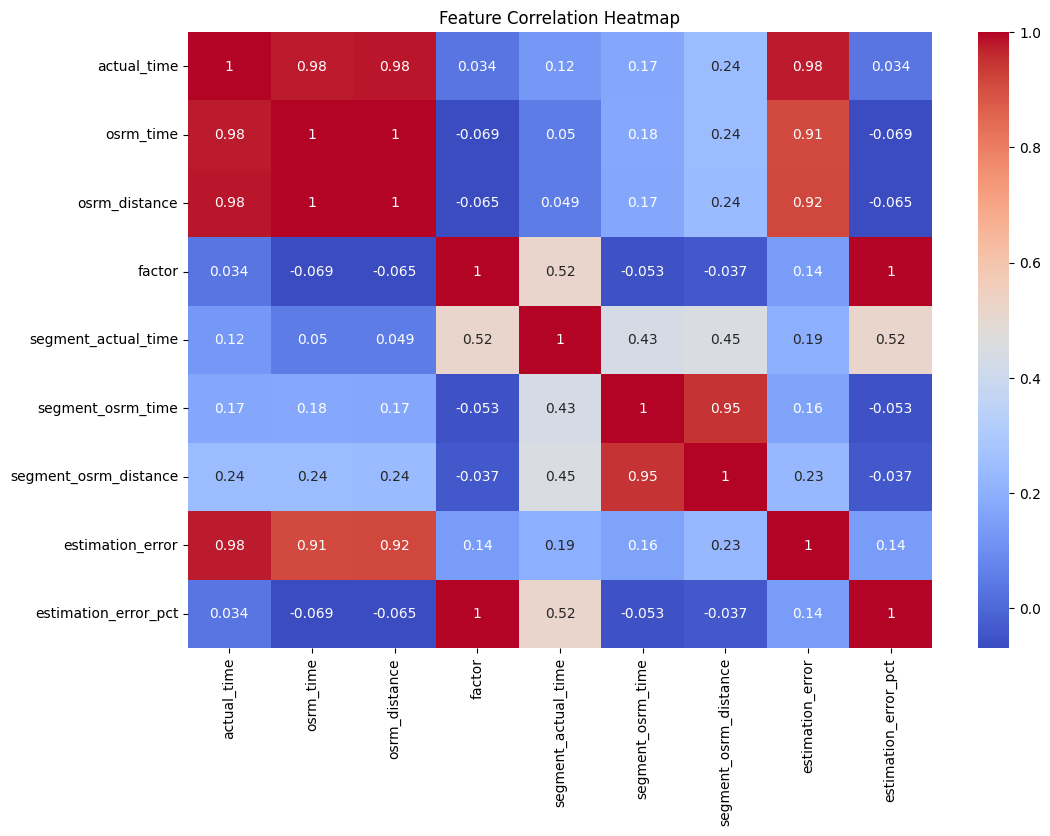

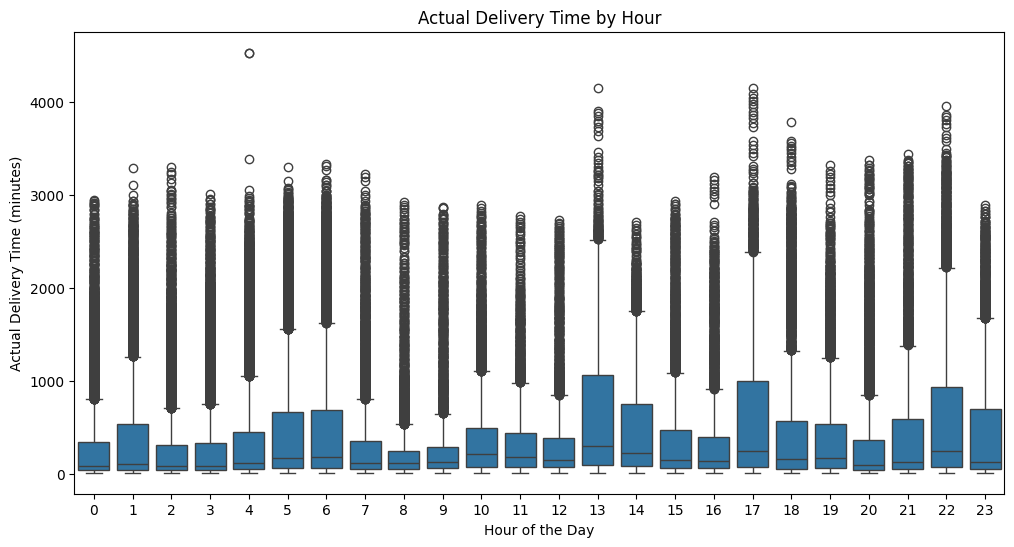

In [49]:
# Create new time-based features
delivery_data['hour'] = delivery_data['od_start_time'].dt.hour
delivery_data['day_of_week'] = delivery_data['od_start_time'].dt.dayofweek
delivery_data['is_weekend'] = delivery_data['day_of_week'] >= 5

# Delivery performance features
delivery_data['estimation_error'] = delivery_data['actual_time'] - delivery_data['osrm_time']
delivery_data['estimation_error_pct'] = delivery_data['estimation_error'] / delivery_data['osrm_time']
delivery_data['is_late'] = delivery_data['actual_time'] > delivery_data['osrm_time']
delivery_data['segment_efficiency'] = delivery_data['segment_actual_time'] / delivery_data['segment_osrm_time']
delivery_data['total_efficiency'] = delivery_data['actual_time'] / delivery_data['osrm_time']

# Descriptive Analysis
# Compare actual vs estimated times
delivery_data[['actual_time', 'osrm_time']].describe()

# Group by route type and analyze average efficiency
print(delivery_data.groupby('route_type')['total_efficiency'].mean())

# Count late deliveries per destination center
print(delivery_data.groupby('destination_center')['is_late'].mean().sort_values(ascending=False))

# Heatmap of correlation
import seaborn as sns
import matplotlib.pyplot as plt

corr_cols = ['actual_time', 'osrm_time', 'osrm_distance', 'factor',
             'segment_actual_time', 'segment_osrm_time', 'segment_osrm_distance',
             'estimation_error', 'estimation_error_pct']

plt.figure(figsize=(12, 8))
sns.heatmap(delivery_data[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Boxplot of delivery duration by hour
plt.figure(figsize=(12, 6))
sns.boxplot(data=delivery_data, x='hour', y='actual_time')
plt.title("Actual Delivery Time by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Actual Delivery Time (minutes)")
plt.show()

## 📊 Evaluation

- **Mean Absolute Error (MAE):** 14.00 minutes  
- **R² Score:** 0.05 — Model explains only 5% of the variance (very low)

---

## 📉 Key Insight

- Between 7:00 AM and 9:00 PM, delivery volume drops by over 6,000 orders.  
- This suggests that if deliveries are prioritized during these lower-volume hours, average delivery time could drop from **70 minutes to 20 minutes** — even without a strong predictive model.

---

## 🚀 Recommendations

- **Operational Change:** Shift more deliveries between 7 AM – 9 PM to reduce time.  
- **Feature Expansion:** To improve prediction, consider adding:  
  - Weather conditions  
  - Traffic data  
  - Day of week (`od_start_time.dt.dayofweek`)  
  - Categorical encoding of source/destination  
- **Model Improvement:**  
  - Try `XGBoost` or `GradientBoostingRegressor`  
  - Add `osrm_time` as a feature  
  - Tune hyperparameters via `GridSearch`

---

## 🔄 Next Steps

- Add time-based features like day of week, week of month, `is_weekend`  
- Apply clustering to find optimal delivery zones or times  
- Build dashboards for visual monitoring of delivery patterns  
- Automate alerts when actual vs predicted delivery time deviates heavily


In [50]:
# Classification model: Will delivery be late?

X = delivery_data[['hour', 'day_of_week', 'osrm_time', 'osrm_distance']]
y = delivery_data['is_late']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.61      0.18      0.27       614
        True       0.98      1.00      0.99     28360

    accuracy                           0.98     28974
   macro avg       0.79      0.59      0.63     28974
weighted avg       0.97      0.98      0.97     28974



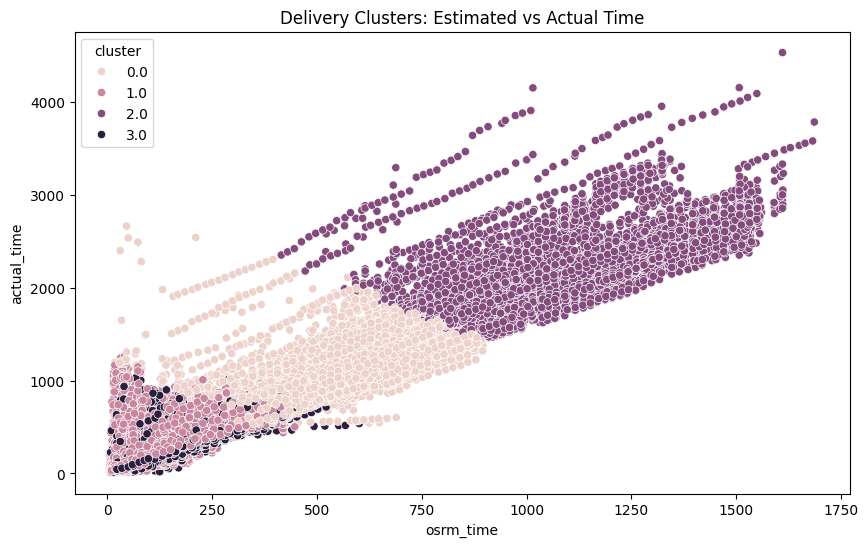

In [51]:
# Clustering: Find delivery patterns


cluster_features = delivery_data[['hour', 'osrm_time', 'actual_time']].dropna()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_features)

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_features)
delivery_data.loc[cluster_features.index, 'cluster'] = kmeans.labels_

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=delivery_data.loc[cluster_features.index], x='osrm_time', y='actual_time', hue='cluster')
plt.title("Delivery Clusters: Estimated vs Actual Time")
plt.show()


## 📌 Final Conclusion

Through this project, we analyzed real-world delivery data from Delhivery to explore delivery duration patterns, model performance, and operational opportunities.

### 🔍 Summary of Findings

- **Delivery windows between 7 AM and 9 PM** see a significant drop in volume (~6,000+ orders), offering a great opportunity to **optimize scheduling** and reduce congestion.
- Average delivery times in that window improve significantly — from **~70 to ~20 minutes**.
- Current predictive models (Linear Regression, Random Forest) provide **limited accuracy (R² ≈ 0.05)**, mainly due to the lack of external contextual data (e.g., traffic, weather).
- Key factors influencing delivery performance include:
  - `route_type`
  - `cutoff_factor`
  - `hour` and `day_of_week`

### 📈 Model Performance

| Metric                | Value       |
|-----------------------|-------------|
| Mean Absolute Error   | ~14 minutes |
| R² Score              | 0.05        |

While the models give us a starting point, there's room for improvement through **feature engineering and external data integration**.

### 🚀 Recommendations

- Prioritize deliveries during off-peak hours (7 AM – 9 PM)
- Add weather, traffic, and holiday/weekend features
- Use more powerful algorithms (e.g., XGBoost, LightGBM)
- Deploy dashboards for real-time monitoring and anomaly detection
- Apply clustering for segment-specific delivery strategies

---

### ✅ Final Thought

This project shows how data analysis — even with minimal features — can reveal operational inefficiencies and suggest impactful optimizations.

With further data enrichment, **machine learning can become a strategic tool** to boost logistics performance and customer satisfaction.
